# Exploratory Data Analysis for Insurance Premium Prediction

This notebook performs a comprehensive exploratory data analysis on the insurance premium dataset to understand the data characteristics, identify patterns, and inform feature engineering and modeling decisions.

**Author:** Erick K. Yegon, PhD (keyegon@gmail.com)

In [1]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

# Set plot style
sns.set()
sns.set_palette('viridis')
warnings.filterwarnings('ignore')

# Add the parent directory to the path so we can import the package
sys.path.append(os.path.abspath('..'))

## 1. Data Loading and Initial Inspection

In [2]:
# Load the data
data_path = '../data/premiums.xlsx'
df = pd.read_excel(data_path)

# Rename columns with spaces to use underscores for consistency
if 'Number Of Dependants' in df.columns:
    df = df.rename(columns={'Number Of Dependants': 'Number_Of_Dependants'})

if 'Medical History' in df.columns:
    df = df.rename(columns={'Medical History': 'Medical_History'})

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print(f"\nColumns: {df.columns.tolist()}")

Dataset shape: (50000, 13)
Number of samples: 50000
Number of features: 13

Columns: ['Age', 'Gender', 'Region', 'Marital_status', 'Number_Of_Dependants', 'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level', 'Income_Lakhs', 'Medical_History', 'Insurance_Plan', 'Annual_Premium_Amount']


In [3]:
# Display the first few rows of the dataset
df.head()

,Age,Gender,Region,Marital_status,Number_Of_Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical_History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [4]:
# Get data types and summary statistics
print("Data Types:")
print(df.dtypes)

print("\nSummary Statistics:")
df.describe(include='all').T

Data Types:
Age                       int64
Gender                   object
Region                   object
Marital_status           object
Number_Of_Dependants      int64
BMI_Category             object
Smoking_Status           object
Employment_Status        object
Income_Level             object
Income_Lakhs              int64
Medical_History          object
Insurance_Plan           object
Annual_Premium_Amount     int64
dtype: object

Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,50000.0,NaN,NaN,NaN,34.59348,15.000437,18.0,22.0,31.0,45.0,356.0
Gender,50000,2,Male,27480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region,50000,4,Southeast,17520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_status,50000,2,Unmarried,25681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_Of_Dependants,50000.0,NaN,NaN,NaN,1.71208,1.498248,-3.0,0.0,2.0,3.0,5.0
BMI_Category,50000,4,Normal,23511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Smoking_Status,49989,6,No Smoking,27366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Employment_Status,49998,3,Salaried,20968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income_Level,49987,4,<10L,18667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income_Lakhs,50000.0,NaN,NaN,NaN,23.0182,24.219197,1.0,7.0,17.0,31.0,930.0


## 2. Data Quality Assessment

Missing Values Analysis:
                   Missing Values  Percentage
Smoking_Status                 11       0.022
Employment_Status               2       0.004
Income_Level                   13       0.026


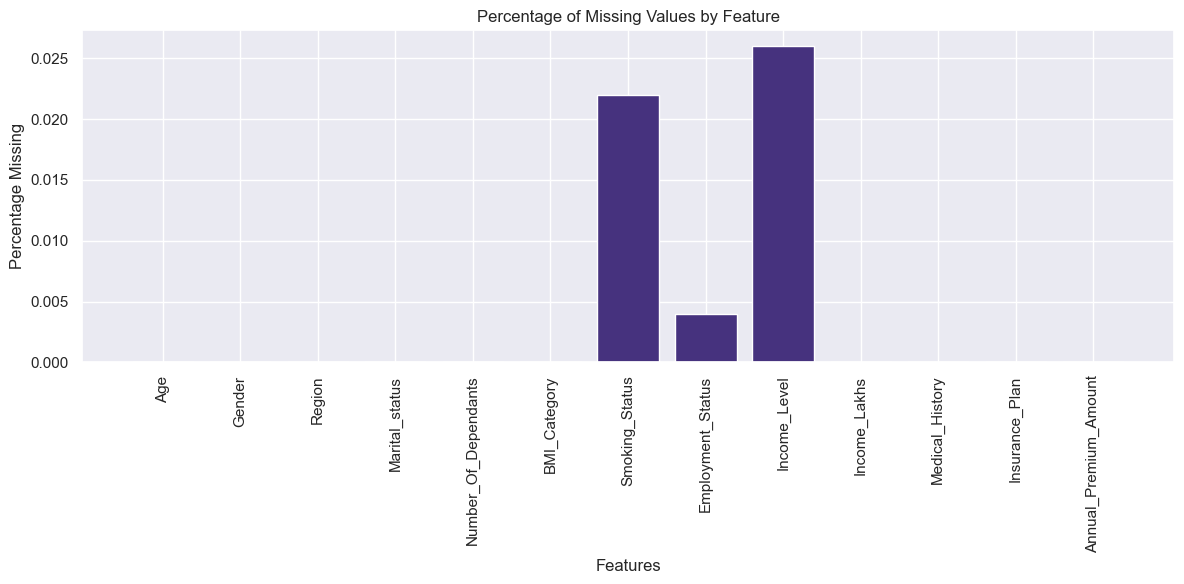

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Values Analysis:")
print(missing_df[missing_df['Missing Values'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(12, 6))
    plt.bar(missing_df.index, missing_df['Percentage'])
    plt.title('Percentage of Missing Values by Feature')
    plt.xlabel('Features')
    plt.ylabel('Percentage Missing')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset.")

In [6]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print("Sample of duplicate rows:")
    df[df.duplicated(keep='first')].head()

Number of duplicate rows: 0


In [7]:
# Check for outliers in numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound, len(outliers)

# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > threshold]
    return outliers, len(outliers)

# Display outlier information for numerical features
print("Outlier Analysis:")
for column in numerical_features:
    if column != 'Annual_Premium_Amount':  # Skip the target variable
        _, lower, upper, count_iqr = detect_outliers_iqr(df, column)
        _, count_zscore = detect_outliers_zscore(df, column)
        print(f"\n{column}:")
        print(f"  IQR Method: {count_iqr} outliers (bounds: {lower:.2f}, {upper:.2f})")
        print(f"  Z-score Method: {count_zscore} outliers (threshold: 3)")

Outlier Analysis:

Age:
  IQR Method: 58 outliers (bounds: -12.50, 79.50)
  Z-score Method: 58 outliers (threshold: 3)

Number_Of_Dependants:
  IQR Method: 0 outliers (bounds: -4.50, 7.50)
  Z-score Method: 32 outliers (threshold: 3)

Income_Lakhs:
  IQR Method: 3561 outliers (bounds: -29.00, 67.00)
  Z-score Method: 549 outliers (threshold: 3)


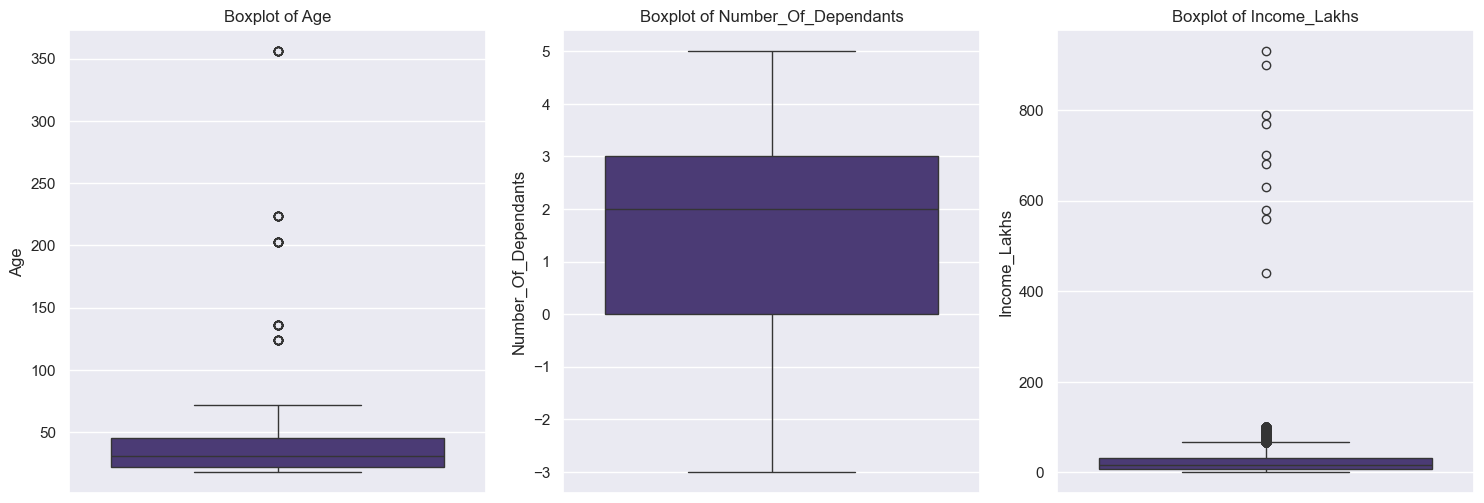

In [8]:
# Visualize outliers using box plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_features):
    if column != 'Annual_Premium_Amount':  # Skip the target variable for now
        plt.subplot(2, 3, i+1)
        sns.boxplot(y=df[column])
        plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

## 3. Distribution Analysis

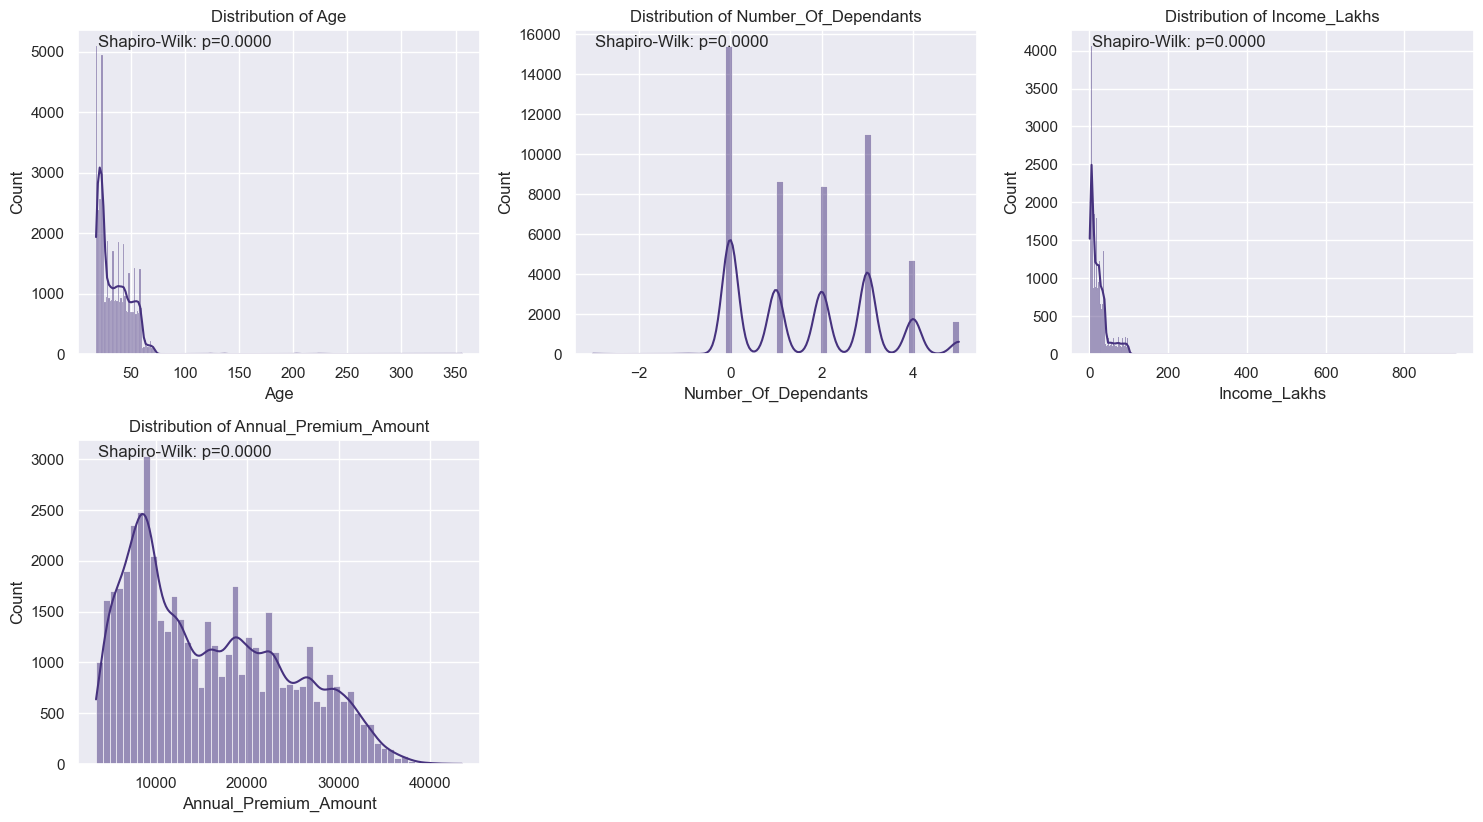

In [9]:
# Analyze distributions of numerical features
plt.figure(figsize=(15, 12))
for i, column in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    
    # Add normality test results
    if len(df[column]) > 3:  # Need at least 3 samples for normality test
        stat, p = stats.shapiro(df[column].sample(min(5000, len(df[column]))))
        plt.annotate(f'Shapiro-Wilk: p={p:.4f}', xy=(0.05, 0.95), xycoords='axes fraction')
plt.tight_layout()
plt.show()

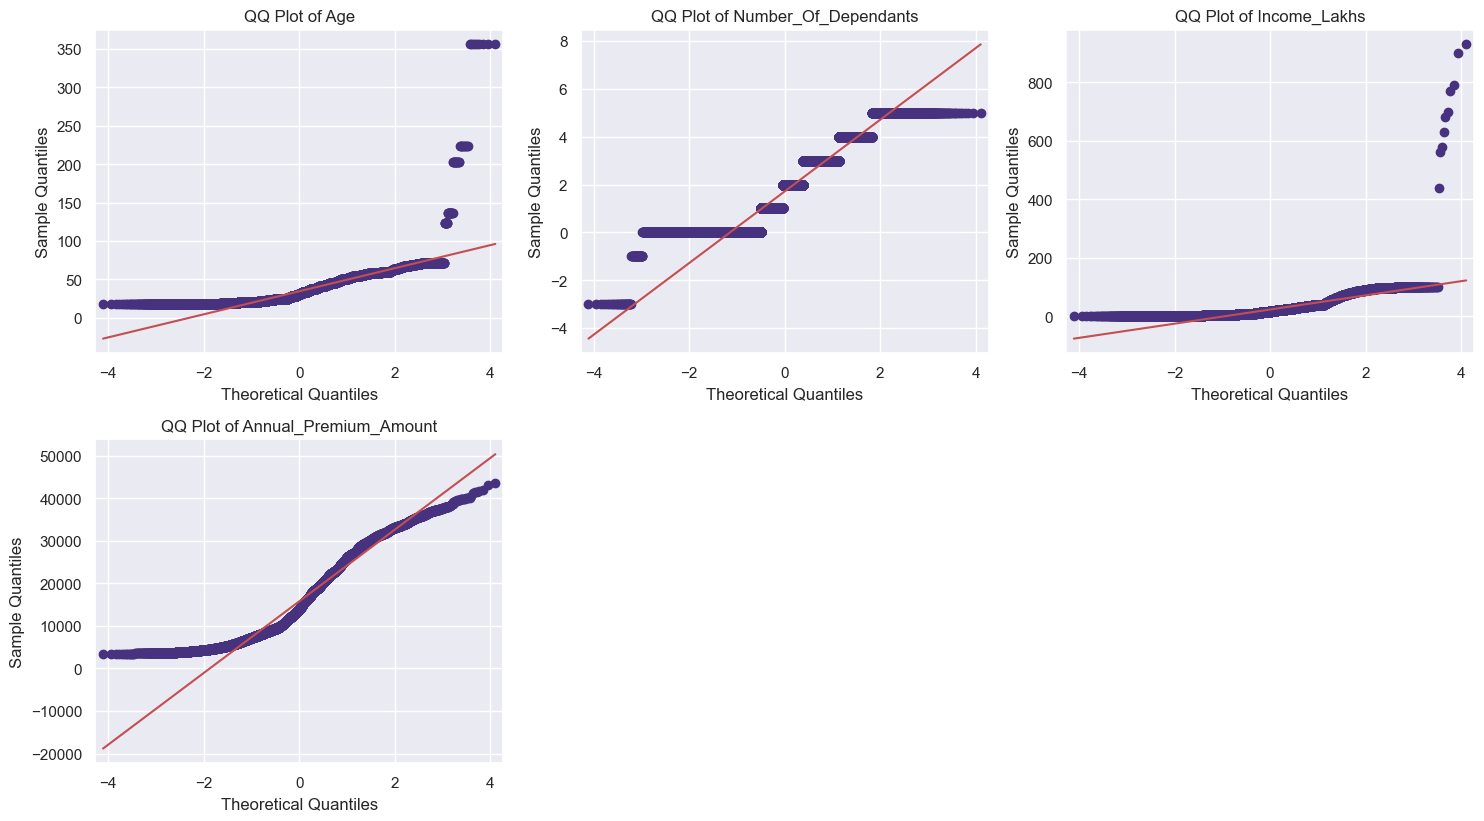

In [10]:
# QQ plots for numerical features to check normality
plt.figure(figsize=(15, 12))
for i, column in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    qqplot(df[column], line='s', ax=plt.gca())
    plt.title(f'QQ Plot of {column}')
plt.tight_layout()
plt.show()

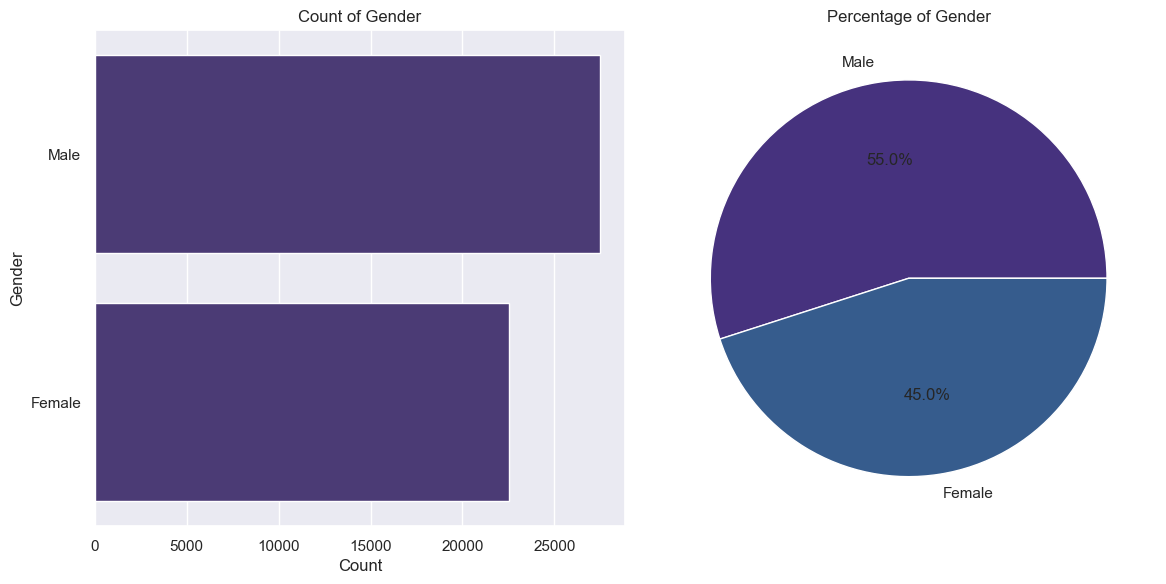


Gender - Category Distribution:
        Count  Percentage
Gender                   
Male    27480       54.96
Female  22520       45.04


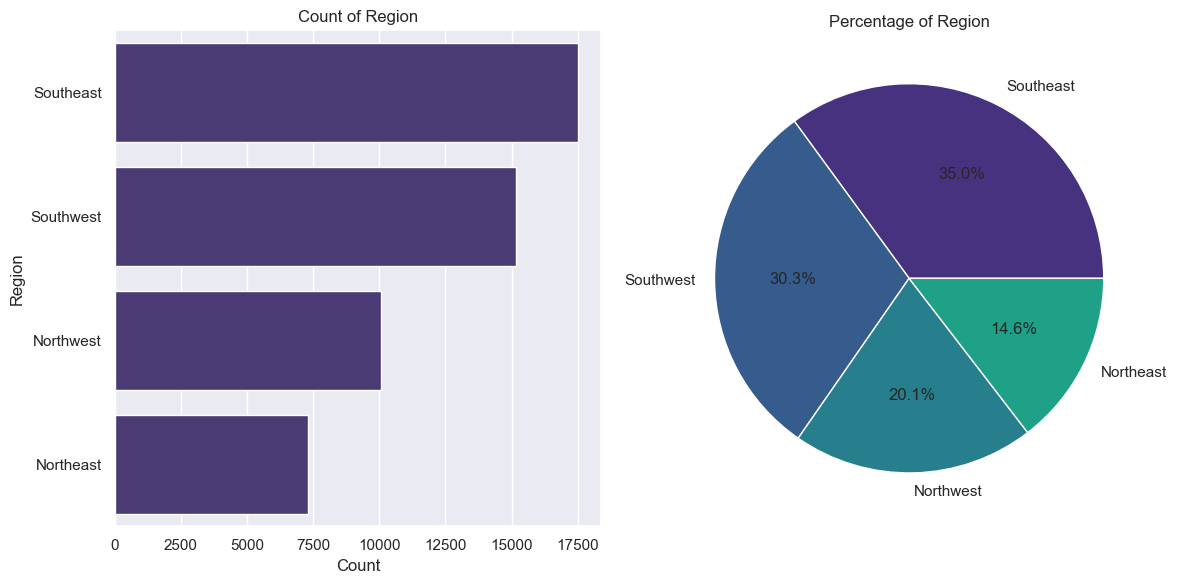


Region - Category Distribution:
           Count  Percentage
Region                      
Southeast  17520      35.040
Southwest  15152      30.304
Northwest  10044      20.088
Northeast   7284      14.568


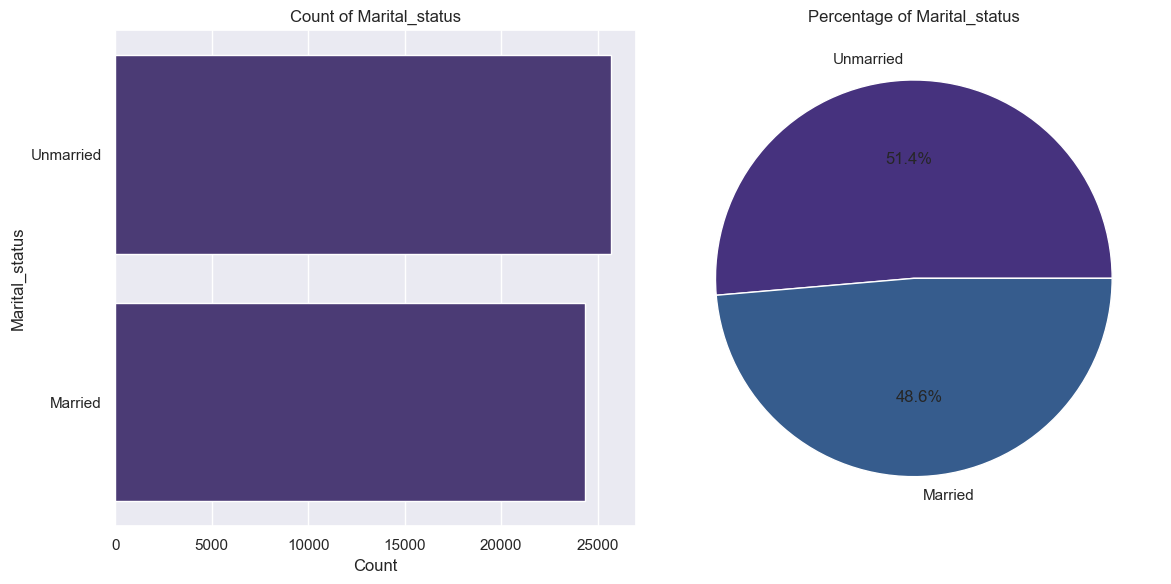


Marital_status - Category Distribution:
                Count  Percentage
Marital_status                   
Unmarried       25681      51.362
Married         24319      48.638


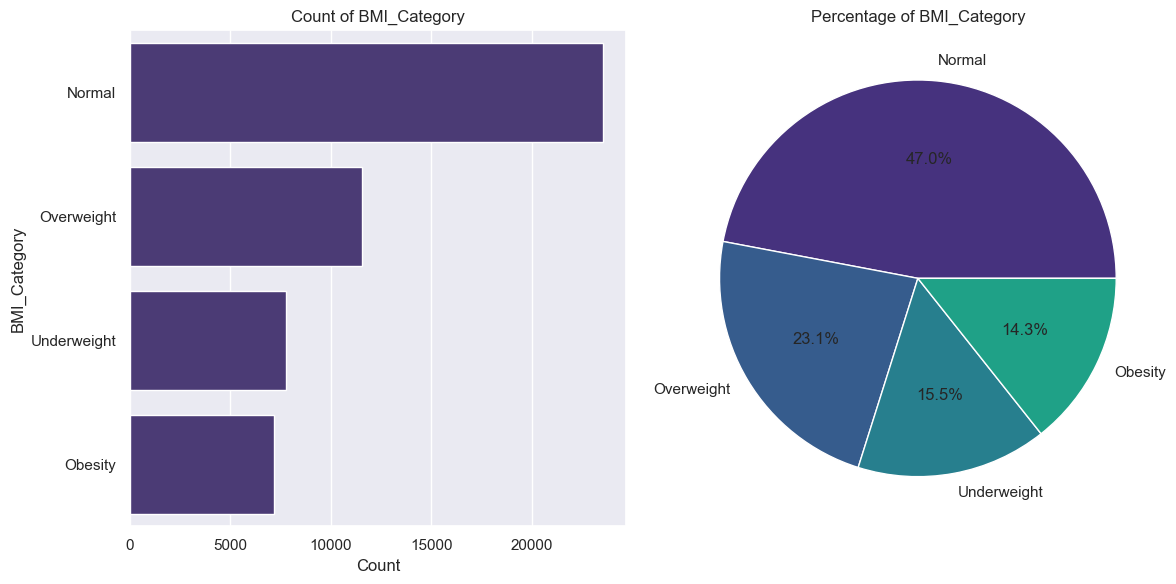


BMI_Category - Category Distribution:
              Count  Percentage
BMI_Category                   
Normal        23511      47.022
Overweight    11556      23.112
Underweight    7768      15.536
Obesity        7165      14.330


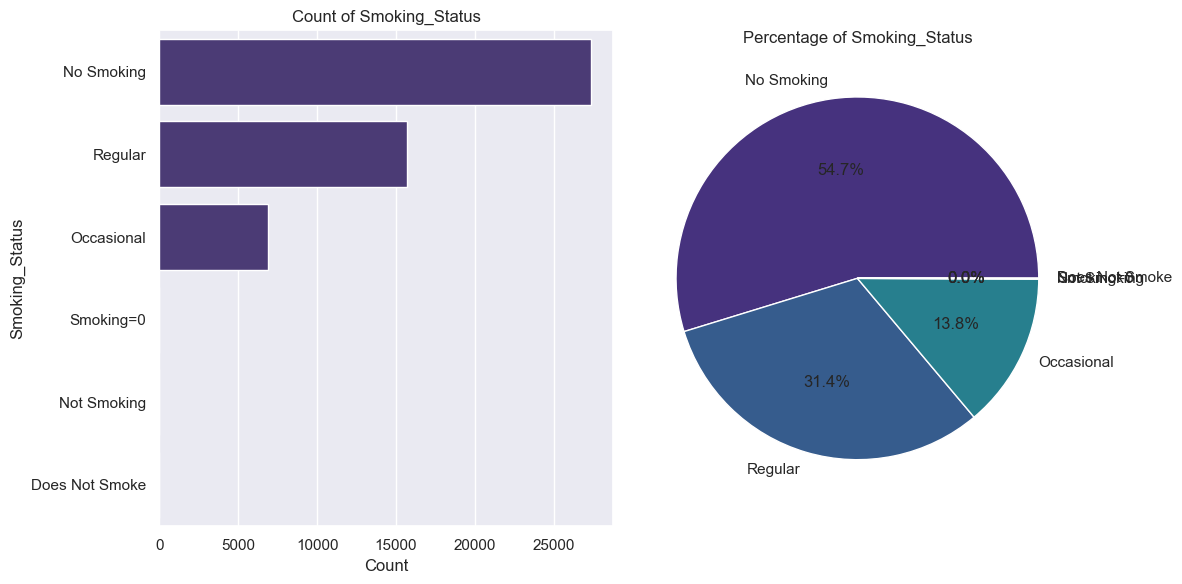


Smoking_Status - Category Distribution:
                Count  Percentage
Smoking_Status                   
No Smoking      27366      54.732
Regular         15686      31.372
Occasional       6915      13.830
Smoking=0           8       0.016
Not Smoking         8       0.016
Does Not Smoke      6       0.012


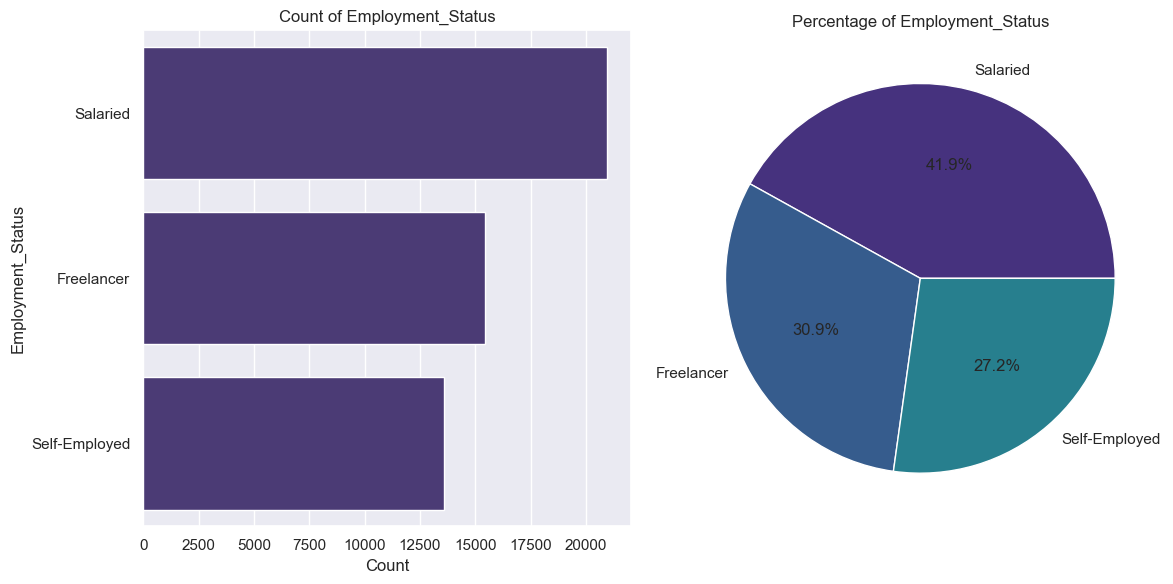


Employment_Status - Category Distribution:
                   Count  Percentage
Employment_Status                   
Salaried           20968      41.936
Freelancer         15428      30.856
Self-Employed      13602      27.204


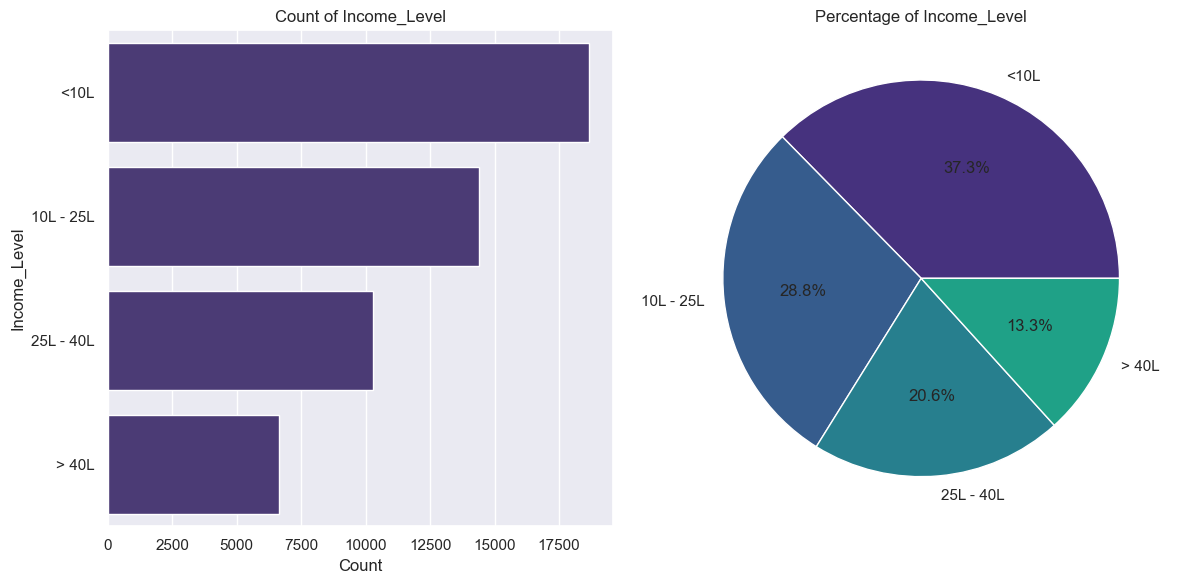


Income_Level - Category Distribution:
              Count  Percentage
Income_Level                   
<10L          18667      37.334
10L - 25L     14391      28.782
25L - 40L     10288      20.576
> 40L          6641      13.282


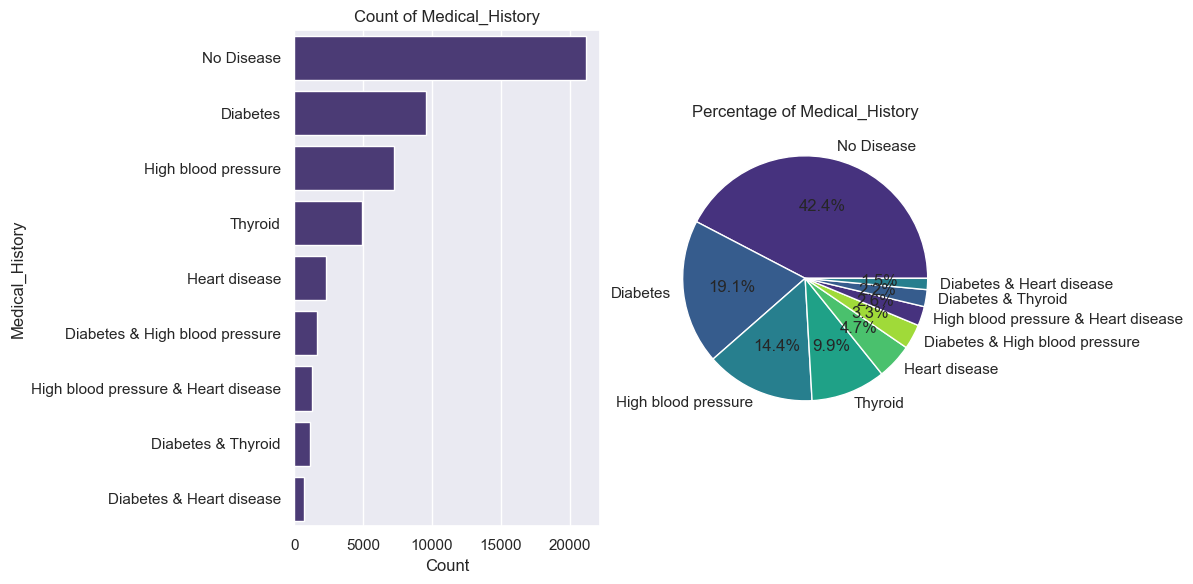


Medical_History - Category Distribution:
                                     Count  Percentage
Medical_History                                       
No Disease                           21177      42.354
Diabetes                              9549      19.098
High blood pressure                   7223      14.446
Thyroid                               4928       9.856
Heart disease                         2345       4.690
Diabetes & High blood pressure        1641       3.282
High blood pressure & Heart disease   1279       2.558
Diabetes & Thyroid                    1119       2.238
Diabetes & Heart disease               739       1.478


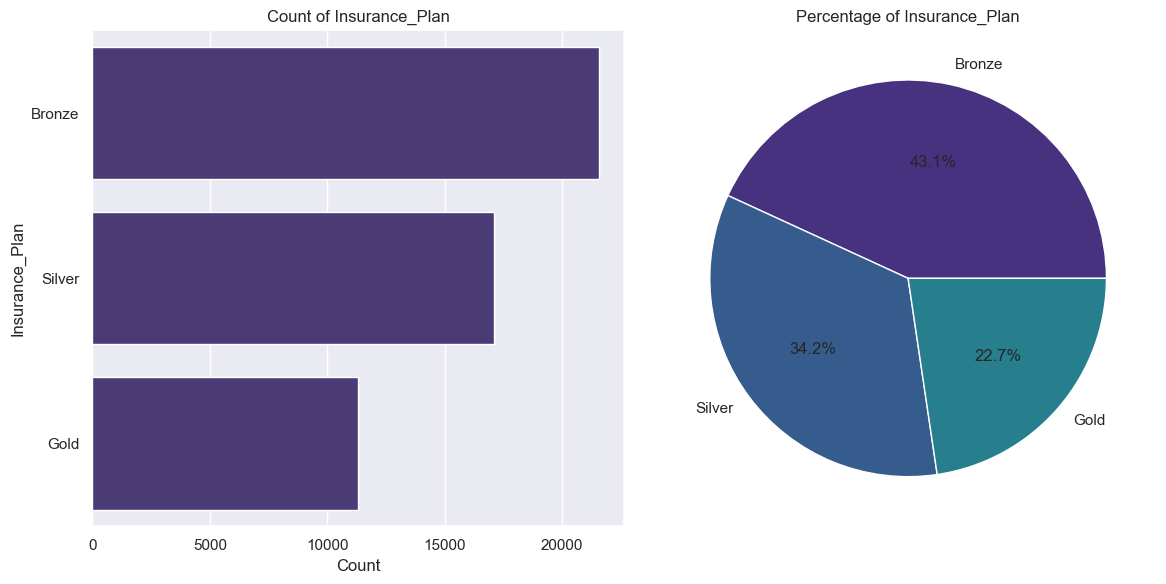


Insurance_Plan - Category Distribution:
                Count  Percentage
Insurance_Plan                   
Bronze          21573      43.146
Silver          17098      34.196
Gold            11329      22.658


In [11]:
# Analyze distributions of categorical features
categorical_features = df.select_dtypes(include=['object']).columns

for column in categorical_features:
    plt.figure(figsize=(12, 6))
    value_counts = df[column].value_counts()
    
    # Bar plot
    plt.subplot(1, 2, 1)
    sns.countplot(y=column, data=df, order=value_counts.index)
    plt.title(f'Count of {column}')
    plt.xlabel('Count')
    
    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(f'Percentage of {column}')
    
    plt.tight_layout()
    plt.show()
    
    # Print category counts and percentages
    print(f"\n{column} - Category Distribution:")
    category_df = pd.DataFrame({
        'Count': value_counts,
        'Percentage': (value_counts / len(df)) * 100
    })
    print(category_df)

## 4. Target Variable Analysis

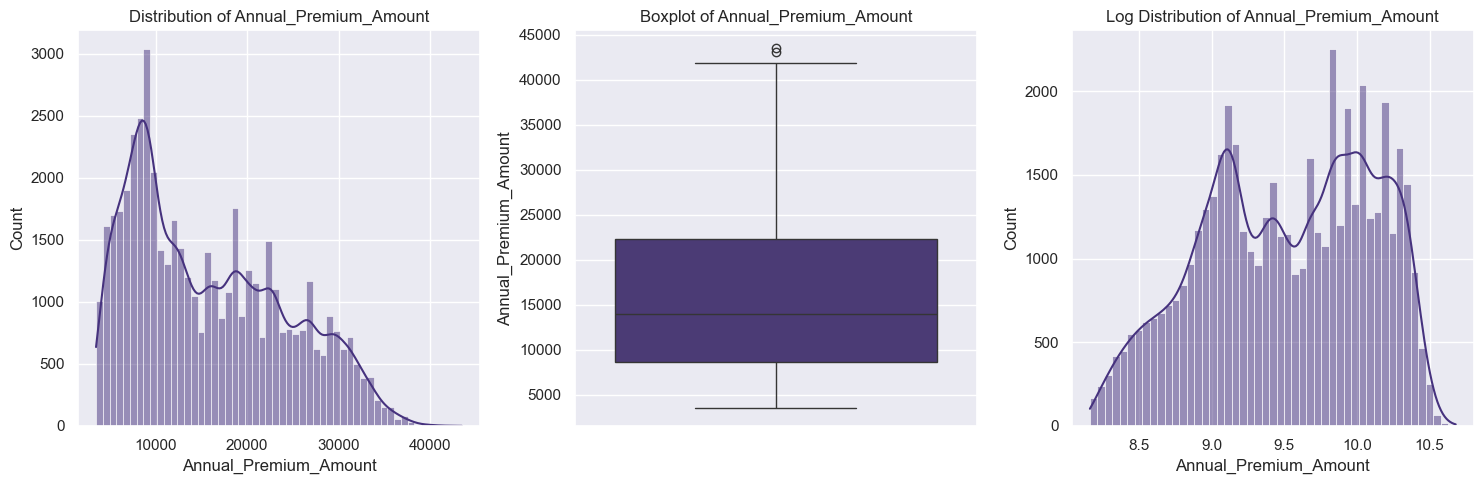


Annual_Premium_Amount - Summary Statistics:
count    50000.000000
mean     15768.116320
std       8419.839675
min       3501.000000
25%       8608.000000
50%      13929.000000
75%      22275.250000
max      43471.000000
Name: Annual_Premium_Amount, dtype: float64

Skewness: 0.5177
Kurtosis: -0.8225
Shapiro-Wilk Test: statistic=0.9364, p-value=0.0000
The target variable is not normally distributed.


In [12]:
# Analyze the target variable (Annual_Premium_Amount)
target = 'Annual_Premium_Amount'

plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 3, 1)
sns.histplot(df[target], kde=True)
plt.title(f'Distribution of {target}')

# Box plot
plt.subplot(1, 3, 2)
sns.boxplot(y=df[target])
plt.title(f'Boxplot of {target}')

# Log transformation to check if it normalizes the distribution
plt.subplot(1, 3, 3)
sns.histplot(np.log1p(df[target]), kde=True)
plt.title(f'Log Distribution of {target}')

plt.tight_layout()
plt.show()

# Summary statistics for the target variable
print(f"\n{target} - Summary Statistics:")
target_stats = df[target].describe()
print(target_stats)

# Additional statistics
print(f"\nSkewness: {df[target].skew():.4f}")
print(f"Kurtosis: {df[target].kurtosis():.4f}")

# Normality test
stat, p = stats.shapiro(df[target].sample(min(5000, len(df[target]))))
print(f"Shapiro-Wilk Test: statistic={stat:.4f}, p-value={p:.4f}")
if p < 0.05:
    print("The target variable is not normally distributed.")
else:
    print("The target variable appears to be normally distributed.")

## 5. Relationship Analysis

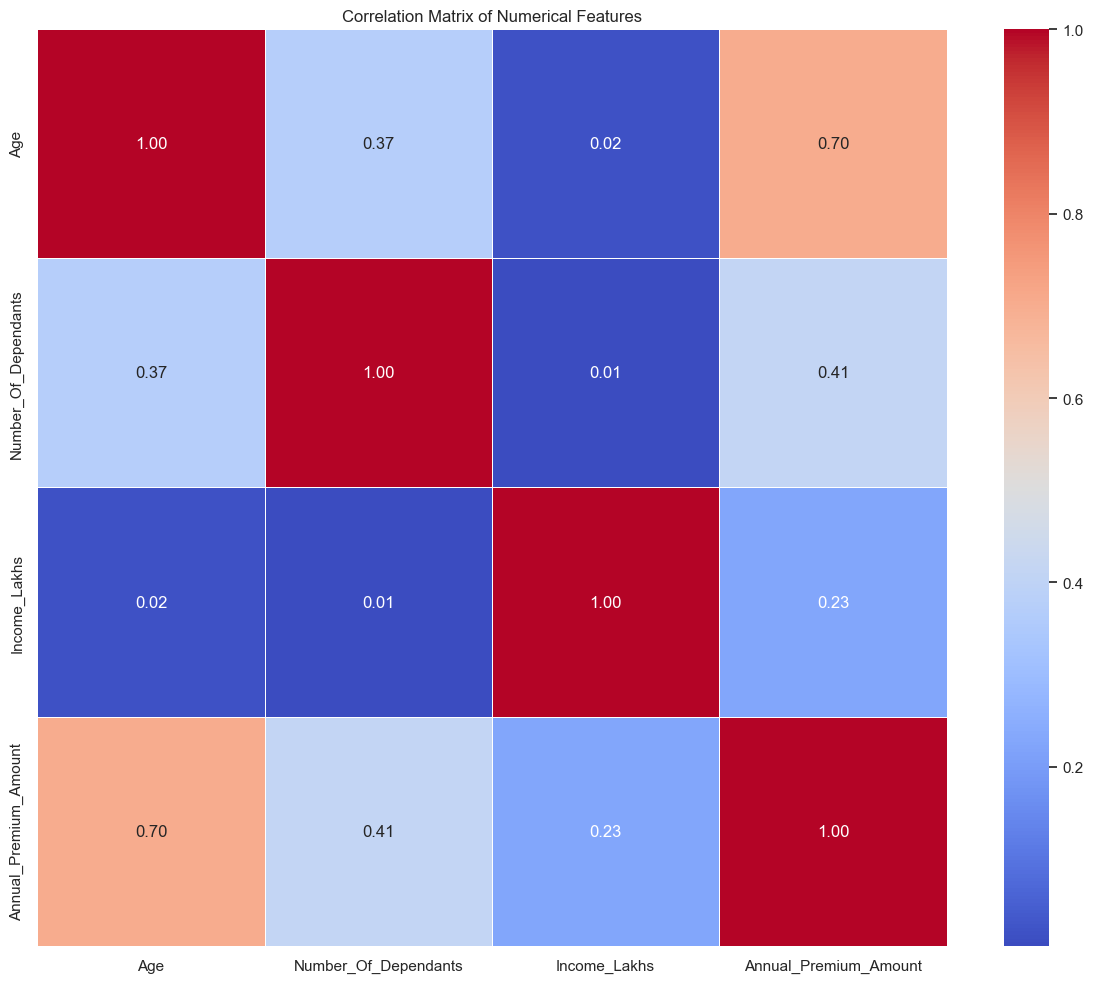

In [13]:
# Correlation analysis for numerical features
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

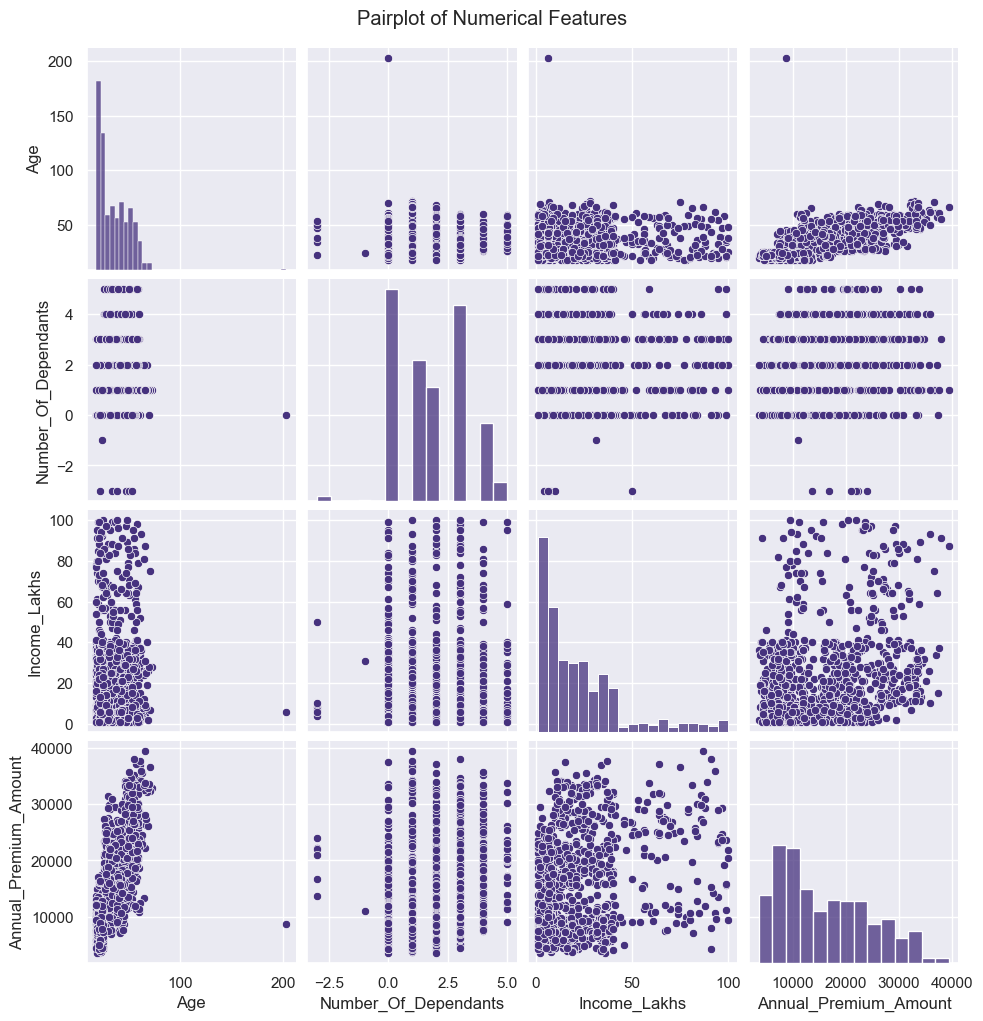

In [14]:
# Pairplot for numerical features
numerical_sample = df[numerical_features].sample(min(1000, len(df)))
sns.pairplot(numerical_sample)
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

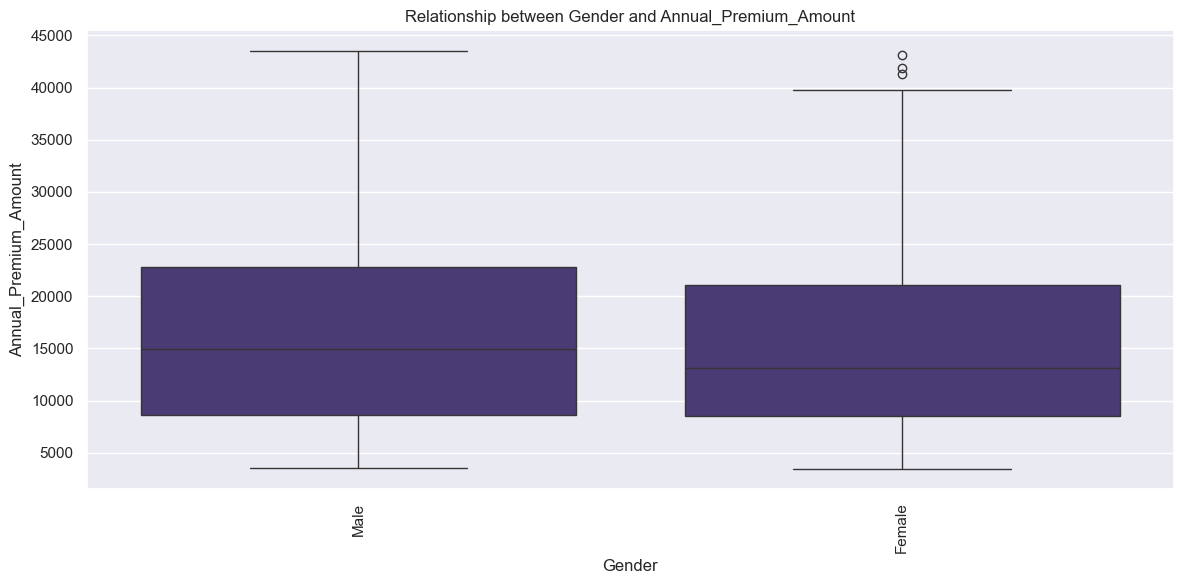

ANOVA test for Gender: F-statistic=210.2150, p-value=0.0000
The mean Annual_Premium_Amount is significantly different across Gender categories.



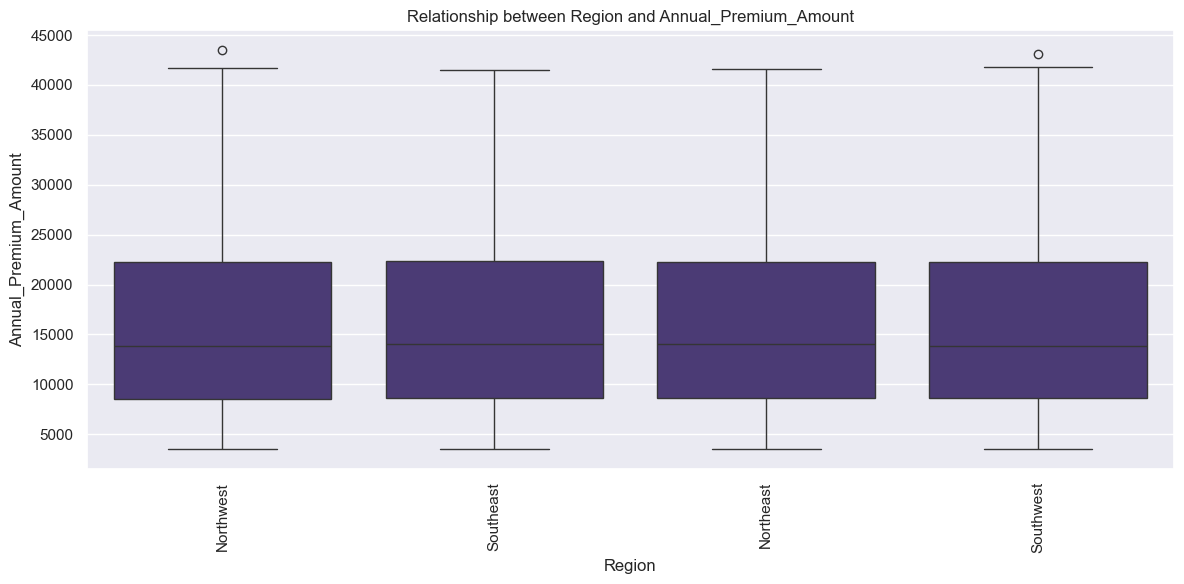

ANOVA test for Region: F-statistic=1.2507, p-value=0.2895
No significant difference in mean Annual_Premium_Amount across Region categories.



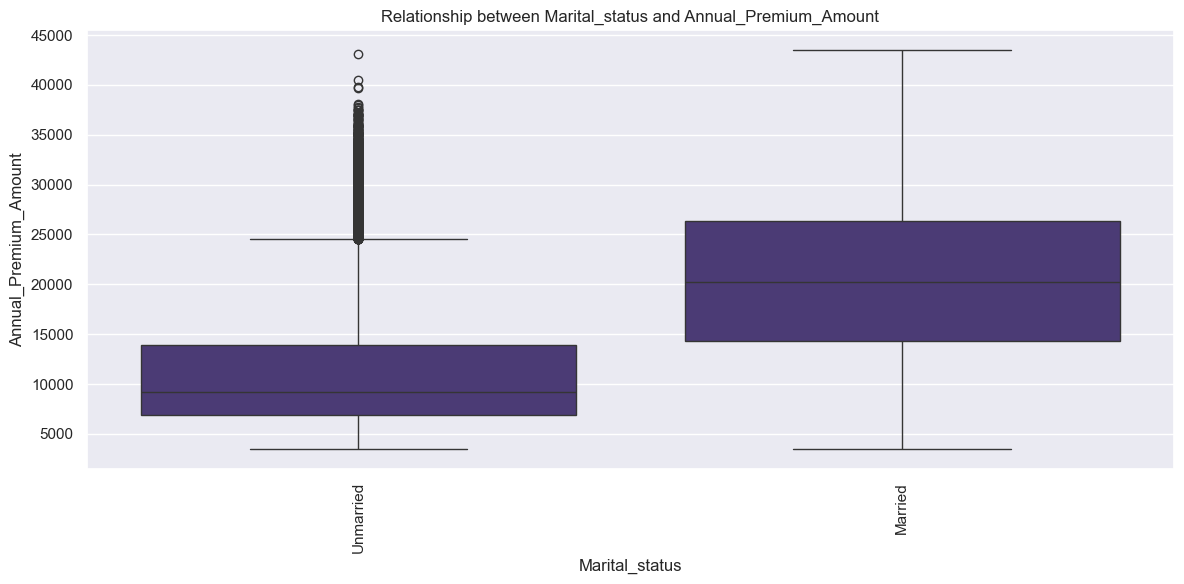

ANOVA test for Marital_status: F-statistic=18202.6808, p-value=0.0000
The mean Annual_Premium_Amount is significantly different across Marital_status categories.



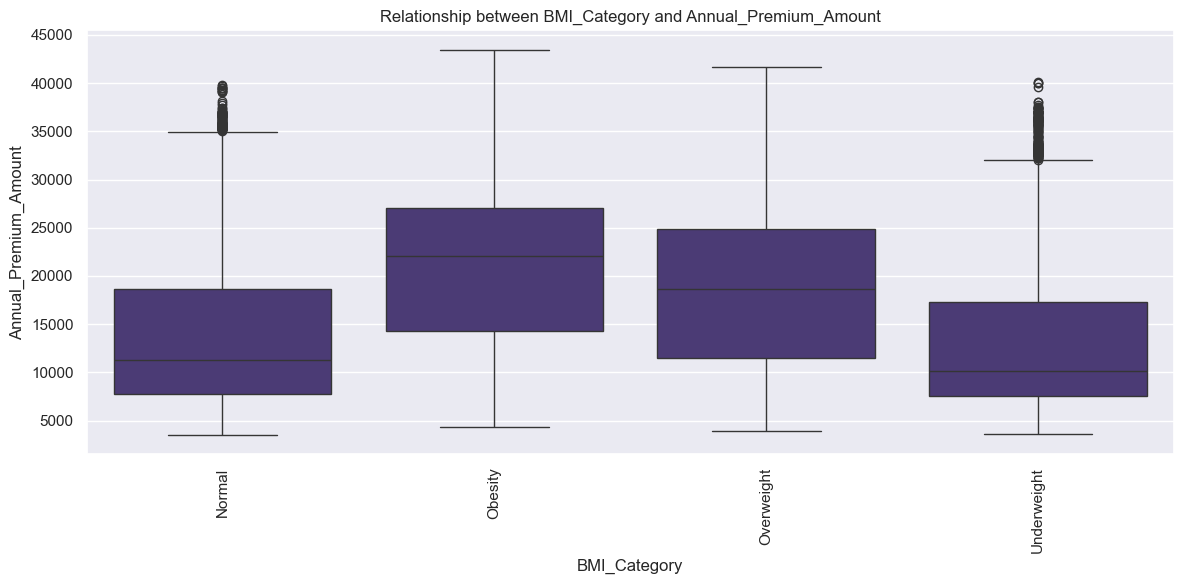

ANOVA test for BMI_Category: F-statistic=2384.2184, p-value=0.0000
The mean Annual_Premium_Amount is significantly different across BMI_Category categories.



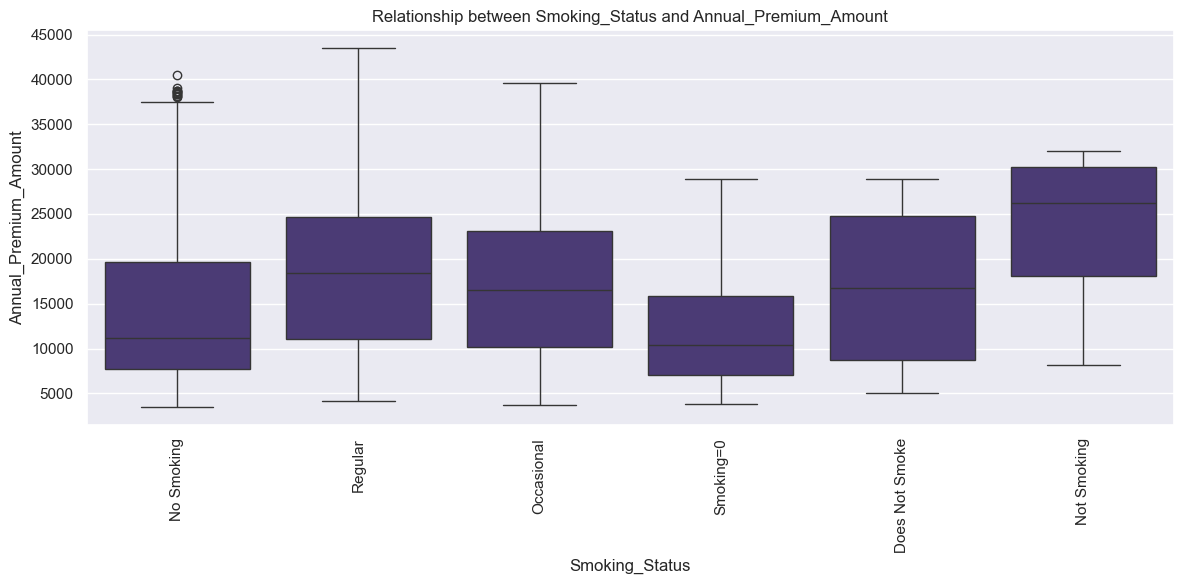

ANOVA test for Smoking_Status: F-statistic=nan, p-value=nan
No significant difference in mean Annual_Premium_Amount across Smoking_Status categories.



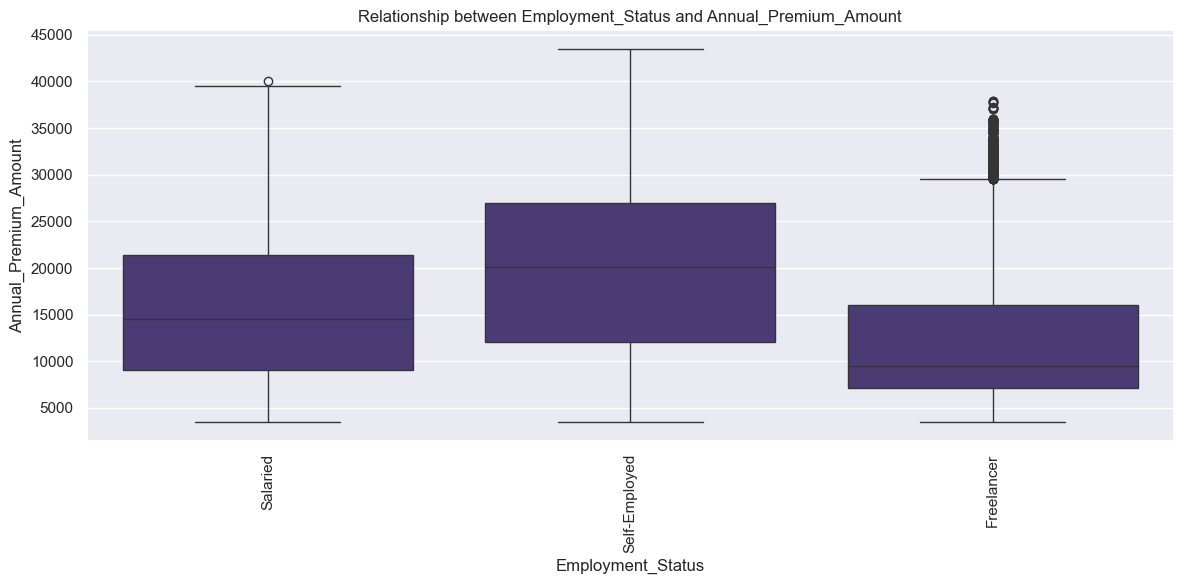

ANOVA test for Employment_Status: F-statistic=nan, p-value=nan
No significant difference in mean Annual_Premium_Amount across Employment_Status categories.



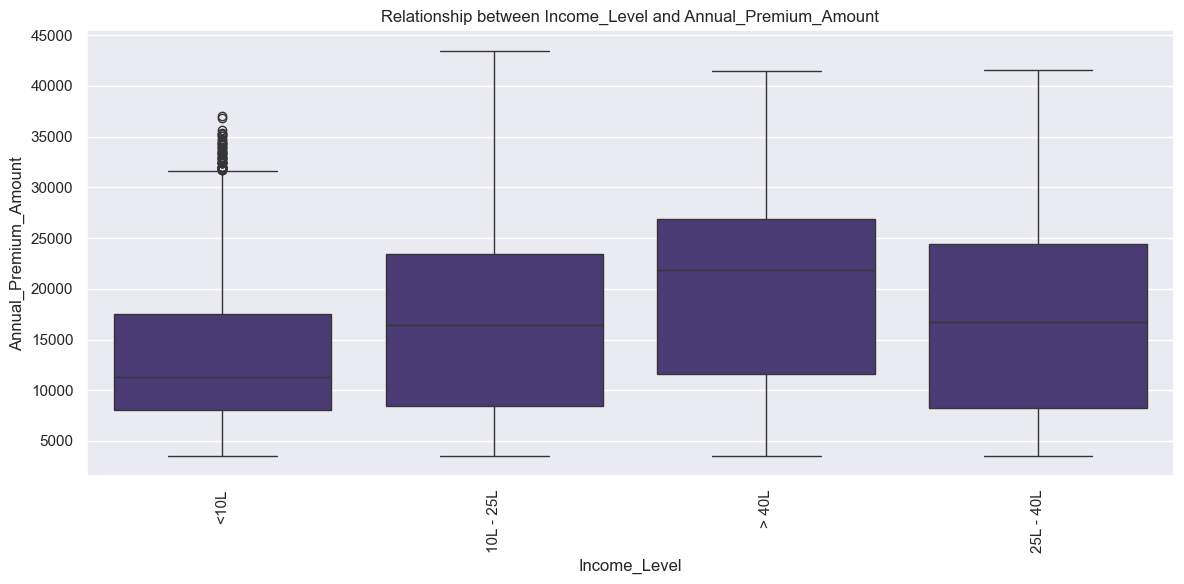

ANOVA test for Income_Level: F-statistic=nan, p-value=nan
No significant difference in mean Annual_Premium_Amount across Income_Level categories.



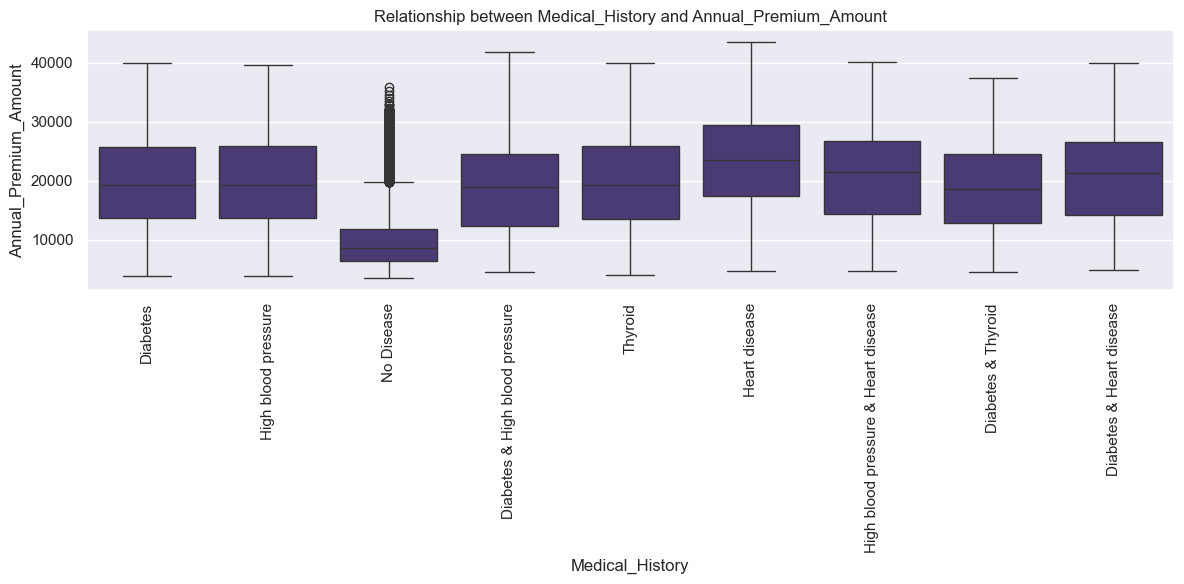

ANOVA test for Medical_History: F-statistic=3446.0162, p-value=0.0000
The mean Annual_Premium_Amount is significantly different across Medical_History categories.



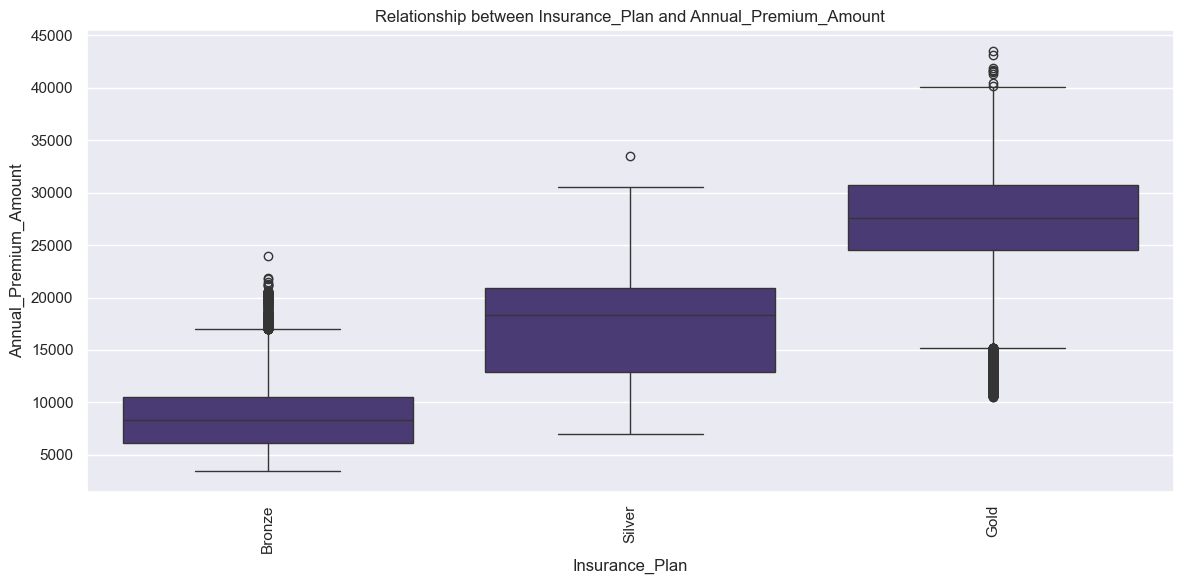

ANOVA test for Insurance_Plan: F-statistic=57382.8782, p-value=0.0000
The mean Annual_Premium_Amount is significantly different across Insurance_Plan categories.



In [15]:
# Relationship between categorical features and target
for column in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=column, y=target, data=df)
    plt.title(f'Relationship between {column} and {target}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    # ANOVA test to check if the means are significantly different
    groups = [df[df[column] == category][target] for category in df[column].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"ANOVA test for {column}: F-statistic={f_stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print(f"The mean {target} is significantly different across {column} categories.\n")
    else:
        print(f"No significant difference in mean {target} across {column} categories.\n")

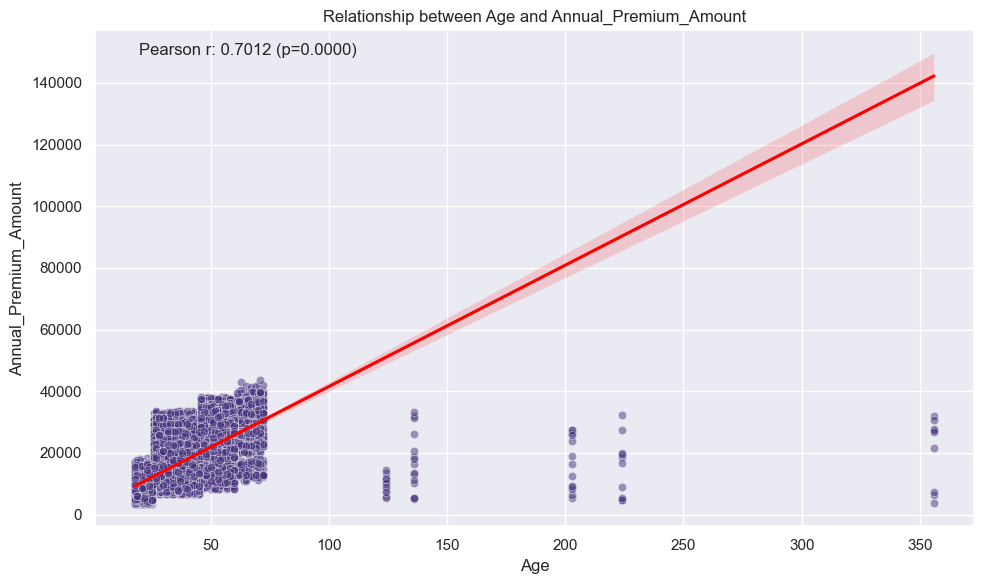

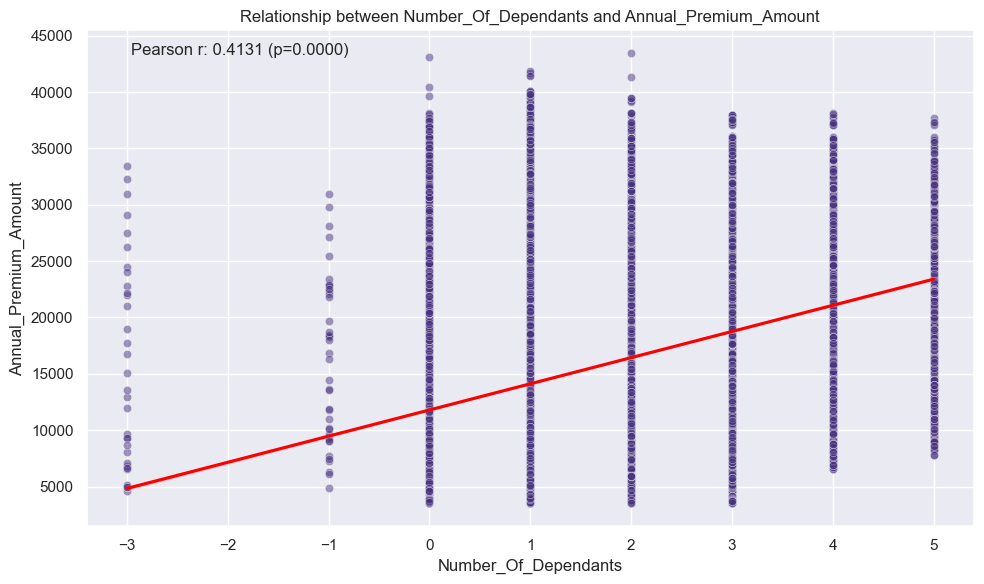

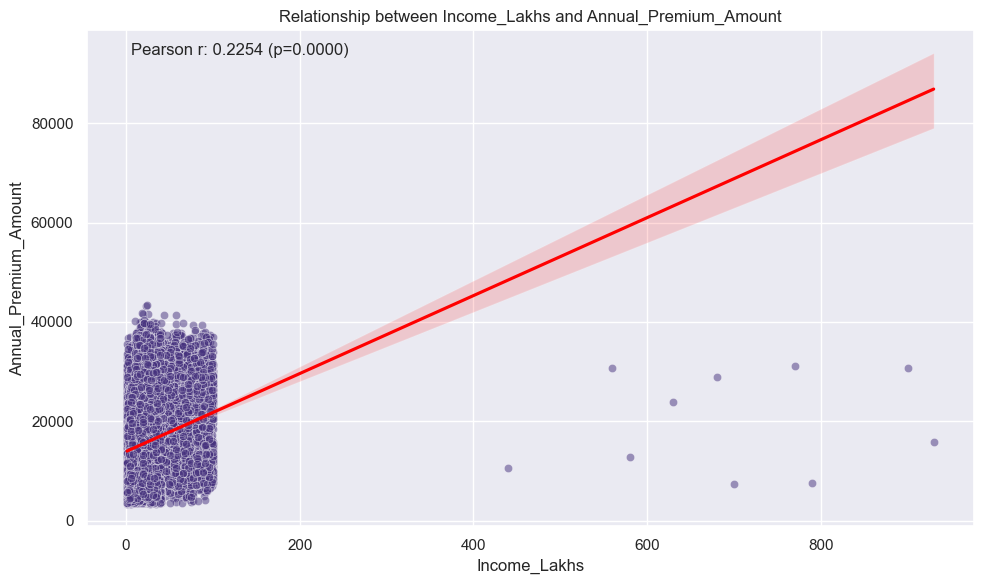

In [16]:
# Relationship between numerical features and target
for column in numerical_features:
    if column != target:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=column, y=target, data=df, alpha=0.5)
        plt.title(f'Relationship between {column} and {target}')
        
        # Add regression line
        sns.regplot(x=column, y=target, data=df, scatter=False, color='red')
        
        # Calculate correlation
        corr, p = stats.pearsonr(df[column], df[target])
        plt.annotate(f'Pearson r: {corr:.4f} (p={p:.4f})', xy=(0.05, 0.95), xycoords='axes fraction')
        
        plt.tight_layout()
        plt.show()

## 6. Feature Importance Analysis

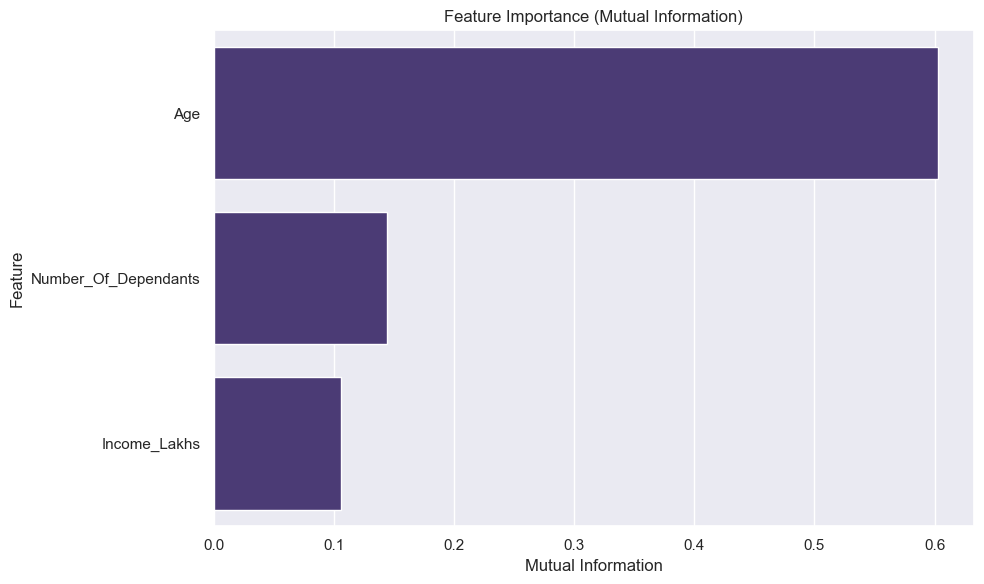

In [17]:
# Calculate mutual information for numerical features
X_numeric = df[numerical_features].drop(columns=[target])
y = df[target]

# Calculate mutual information
mi_scores = mutual_info_regression(X_numeric, y)
mi_df = pd.DataFrame({'Feature': X_numeric.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values('Mutual Information', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df)
plt.title('Feature Importance (Mutual Information)')
plt.tight_layout()
plt.show()

In [18]:
# One-hot encode categorical features for further analysis
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Calculate VIF for numerical features to check multicollinearity
X_numeric = df[numerical_features].drop(columns=[target])
vif_data = pd.DataFrame()
vif_data['Feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print("Variance Inflation Factor (VIF) for Numerical Features:")
print(vif_data.sort_values('VIF', ascending=False))

Variance Inflation Factor (VIF) for Numerical Features:
                Feature       VIF
0                   Age  3.250824
1  Number_Of_Dependants  2.647725
2          Income_Lakhs  1.688372


## 7. Dimensionality Reduction and Visualization

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

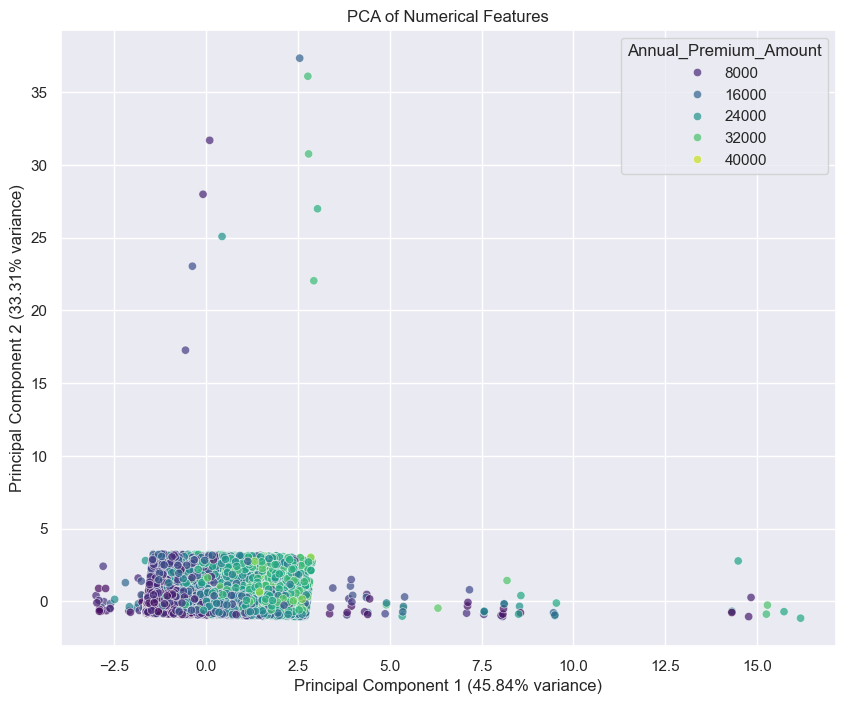

In [19]:
# PCA for visualization
# Prepare data for PCA (standardize and include only numerical features)
X_for_pca = df[numerical_features].drop(columns=[target])
X_scaled = StandardScaler().fit_transform(X_for_pca)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add target variable for coloring
pca_df['Annual_Premium_Amount'] = df[target]

# Visualize PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Annual_Premium_Amount', data=pca_df, palette='viridis', alpha=0.7)
plt.title('PCA of Numerical Features')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(label='Annual Premium Amount')
plt.tight_layout()
plt.show()

# Print explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

## 8. Key Insights and Recommendations

### Key Insights from EDA:

1. **Data Quality**:
   - The dataset contains [X] samples and [Y] features
   - Missing values: [summary of missing values findings]
   - Outliers: [summary of outlier analysis]

2. **Feature Distributions**:
   - Numerical features: [summary of distribution analysis]
   - Categorical features: [summary of category distributions]
   - Target variable: [summary of target distribution]

3. **Relationships**:
   - Strong correlations between [feature pairs]
   - Significant relationships between [categorical features] and the target
   - Most important features based on mutual information: [top features]

4. **Potential Issues**:
   - Multicollinearity between [features]
   - Skewed distributions in [features]
   - Class imbalance in [categorical features]

### Recommendations for Data Preprocessing:

1. **Handling Missing Values**:
   - [Specific recommendations based on findings]

2. **Outlier Treatment**:
   - [Specific recommendations based on findings]

3. **Feature Transformations**:
   - Apply log transformation to the target variable to normalize its distribution
   - Apply appropriate transformations to skewed numerical features

4. **Feature Engineering Opportunities**:
   - Create interaction terms between [features]
   - Develop composite risk scores based on [features]
   - Bin continuous variables like Age into meaningful categories

5. **Feature Selection**:
   - Consider removing highly correlated features
   - Focus on features with high mutual information scores

These insights and recommendations will guide our feature engineering and modeling approaches in the subsequent notebooks.